# Supplemental Figures and Analysis

Some supplemental analyses.

In [1]:
import os
import re
import json
import collections
from pprint import pprint
from pathlib import Path
import sys
import copy 

import numpy as np
import pandas as pd
import scipy
import scipy.io
from natsort import natsorted, index_natsorted
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mp
import matplotlib.pyplot as plt
# matplotlib.use("Agg") # set matplotlib to use the backend that does not require a windowing system
from matplotlib import rc, ticker, cm
from pylab import *
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import matplotlib

from mne import events_from_annotations
import mne
from mne_bids import read_raw_bids, BIDSPath
from mne_bids.path import _find_matching_sidecar, get_entities_from_fname
from mne_bids.tsv_handler import _to_tsv, _from_tsv

from code.utils import _load_turbo, _plot_roc_curve
from code.io import read_participants_tsv
_load_turbo()

# import statistics packages
import scipy.stats

import matplotlib
from matplotlib.colors import LogNorm
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
# Say, "the default sans-serif font is COMIC SANS"
matplotlib.rcParams['font.sans-serif'] = "Arial"
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "arial"

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.metrics import (average_precision_score, roc_auc_score, f1_score,
                            roc_curve, balanced_accuracy_score, accuracy_score, auc)
from sklearn.utils import resample
from sklearn import preprocessing
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
from scipy import interp
from sklearn.metrics import (plot_precision_recall_curve, 
                             average_precision_score, 
                             precision_recall_curve)

# functions related to the feature comparison experiment
import pingouin as pg
import dabest

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
def average_roc(fpr, tpr):
    """Compute average ROC statistics."""
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 200)
    
    n_splits = len(fpr)
    print(f"Computing average ROC over {n_splits} CV splits")
    for i in range(n_splits):
        interp_tpr = np.interp(mean_fpr, fpr[i], tpr[i])
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(auc(mean_fpr, interp_tpr))
    
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)   
    
    std_tpr = np.std(tprs, axis=0)
    return mean_fpr, tprs, aucs

## Subjects

Note that subjects from their original identifiers were defined by clinicians collecting data. There was no sensible schema to naming, numbering or abbreviations, so we mapped these to patients in the paper as ``Patient_01``, ``Patient_02``, ... which is easier to then parse the clinical supplemental table.

In [3]:
# define list of subjects by their original identifiers
subjects = [
    "jh101", "jh103", "jh105", "jh108",
    "la00", "la01", "la02", "la03", "la04", "la05",
    "la06", "la07", "la08", "la09", "la10", "la11",
    "la12", "la13", "la15", "la16", "la17",
    "la20", "la21", "la22", "la23", "la24", "la27", "la28", "la29", "la31",
    "nl01", "nl03", "nl04", "nl05",
    "nl07", "nl08", "nl09", "nl10", "nl13", "nl14", "nl15",
    "nl16", "nl17", "nl18", "nl19", "nl20",
    "nl21", "nl22", "nl23", "nl24",
    "pt1", "pt2", "pt3", "pt6", "pt7",
    "pt8", "pt10", "pt11", "pt12",
    "pt13", "pt14", "pt15", "pt16", "pt17",
    "tvb1", "tvb2", "tvb5", "tvb7",
    "tvb8", "tvb11", "tvb12", "tvb14", "tvb17",
    "tvb18", "tvb19", "tvb23", "tvb27", "tvb28", "tvb29",
    "umf001", "umf002", "umf003", "umf004", "umf005",
    "ummc002", "ummc003", "ummc004", "ummc005", "ummc006",
    "ummc008", "ummc009",
]
print(len(subjects))

91


# Define Paths and some Metadata

In [4]:
# set seed and randomness for downstream reproducibility
seed = 123456
np.random.seed(seed)

In [5]:
# BIDS related directories
bids_root = Path("/Users/adam2392/Dropbox/epilepsy_bids/")
bids_root = Path("/home/adam2392/hdd2/Dropbox/epilepsy_bids/")
bids_root = Path('./data/')
deriv_path = bids_root / 'derivatives'

# output figures somewhere
figdir = Path('./') / 'figures'
figdir = Path(f'/Users/adam2392/Dropbox/Apps/Overleaf/Models of Intracranial EEG Networks For Epileptogenic Zone Localization/figures/')
print(figdir)

# metadata table
excel_fpath = Path(
    "/home/adam2392/hdd2/Dropbox/epilepsy_bids/sourcedata/organized_clinical_datasheet_raw.xlsx"
)
excel_fpath = Path(
    "/Users/adam2392/Dropbox/epilepsy_bids/sourcedata/organized_clinical_datasheet_raw.xlsx"
)

/Users/adam2392/Dropbox/Apps/Overleaf/Models of Intracranial EEG Networks For Epileptogenic Zone Localization/figures


# Load and Combine Result JSONs into 1 data structure
Each cross-validation index was run separately and performance was saved separately into a JSON file. To evaluate all the cross-validation runs together, we load them from disc and combine them into 1 dictionary data structure to analyze.

In [6]:
# identifying strings for each feature representation of the data
feature_names = [
    'fragility',
    "delta", "theta", "alpha", "beta","gamma", "highgamma",
    'correlation-degree', 'correlation-centrality',
    'delta-coherence-centrality', 'theta-coherence-centrality', 'alpha-coherence-centrality',
    'beta-coherence-centrality', 'gamma-coherence-centrality', 'highgamma-coherence-centrality',
    'delta-coherence-degree', 'theta-coherence-degree', 'alpha-coherence-degree',
    'beta-coherence-degree', 'gamma-coherence-degree', 'highgamma-coherence-degree',
]
# clf_type = 'srerf'
clf_type = 'mtmorf'

study_path = deriv_path

In [7]:
# dictionary data structure to hold all the CV experiment results
nested_scores_feature = dict()

for feature_name in feature_names:
    # nested CV estimators
    nested_scores_search_pattern = f'study_nested_scores_{clf_type}_{feature_name}_*.json'
    nested_scores = None
    
    # get all json files that follow that search pattern
    fpaths = (study_path / 'quantile_features' / 'nestedcv_middlethresholds_-80to25_sampledcc_train70').glob(nested_scores_search_pattern)
    fpaths = natsorted(fpaths)
    for json_fpath in fpaths:
        with open(json_fpath, 'r') as fin:
            _nested_scores = json.load(fin)
        
        # either append to the nested dictionary, or create it
        # some magic done to cast numbers in case they were saved in different formats
        if nested_scores is None:
            for key, val in _nested_scores.items():
                if key in ['validate_ytrue']:
                    val = val[0]
                    for idx, y in enumerate(val):
                        val[idx] = y[0]
                else:
                    continue
            nested_scores = _nested_scores
        else:
            for key, val in _nested_scores.items():
                if key == 'validate_ytrue':
                    val = val[0]
                    for idx, y in enumerate(val):
                        val[idx] = y[0]
                nested_scores[key].append(np.array(val).squeeze()) 
    print(f'There should be 10 total CV for {feature_name}. We found {len(fpaths)}')
    nested_scores_feature[feature_name] = nested_scores

There should be 10 total CV for fragility. We found 10
There should be 10 total CV for delta. We found 10
There should be 10 total CV for theta. We found 10
There should be 10 total CV for alpha. We found 10
There should be 10 total CV for beta. We found 10
There should be 10 total CV for gamma. We found 10
There should be 10 total CV for highgamma. We found 10
There should be 10 total CV for correlation-degree. We found 10
There should be 10 total CV for correlation-centrality. We found 10
There should be 10 total CV for delta-coherence-centrality. We found 10
There should be 10 total CV for theta-coherence-centrality. We found 10
There should be 10 total CV for alpha-coherence-centrality. We found 10
There should be 10 total CV for beta-coherence-centrality. We found 10
There should be 10 total CV for gamma-coherence-centrality. We found 10
There should be 10 total CV for highgamma-coherence-centrality. We found 10
There should be 10 total CV for delta-coherence-degree. We found 10
T

# Read in the Participants.tsv File Containing Clinical Metadata

The participants.tsv file contains clinical metadata. Let's get the clinical success rate of our dataset
and total success/failure counts.

In [8]:
pat_df = read_participants_tsv(bids_root)

display(pat_df.head())

,participant_id,age,sex,hand,outcome,engel_score,ilae_score,date_follow_up,ethnicity,years_follow_up,site,clinical_complexity
0,sub-jh101,NaN,NaN,NaN,F,4.0,6.0,NaN,NaN,1.0,JHH,4.0
1,sub-jh102,NaN,NaN,NaN,NR,-1.0,-1.0,NaN,NaN,1.0,JHH,4.0
2,sub-jh103,NaN,NaN,NaN,F,4.0,6.0,NaN,NaN,1.0,JHH,3.0
3,sub-jh104,NaN,NaN,NaN,NR,-1.0,-1.0,NaN,NaN,1.0,JHH,3.0
4,sub-jh105,NaN,NaN,NaN,S,1.0,1.0,NaN,NaN,1.0,JHH,2.0


In [9]:
outcomes = []

# get a list of all the outcomes
for subj in np.unique(subjects):
    # use excel file to set various data points
    pat_row = pat_df[pat_df['participant_id'] == 'sub-' + subj]
    outcomes.append(pat_row['outcome'].values[0])
print(outcomes)

['F', 'F', 'S', 'F', 'S', 'F', 'S', 'F', 'F', 'F', 'F', 'S', 'F', 'F', 'F', 'F', 'F', 'S', 'F', 'F', 'F', 'F', 'S', 'F', 'S', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'S', 'S', 'S', 'S', 'S', 'F', 'S', 'F', 'S', 'S', 'S', 'S', 'F', 'S', 'S', 'S', 'S', 'F', 'S', 'F', 'S', 'F', 'S', 'F', 'S', 'S', 'S', 'S', 'S', 'F', 'F', 'S', 'F', 'F', 'F', 'F', 'S', 'S', 'F', 'F', 'F', 'F', 'F', 'F', 'S', 'F', 'S', 'S', 'F', 'F', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S']


In [10]:
auc_feat_names = []
auc_feat_scores = []

for feature_name, nested_scores in nested_scores_feature.items():
    # summarize the boot-strapped samples
    fprs, tprs = nested_scores['validate_fpr'], nested_scores['validate_tpr']
    # aucs = [auc(fpr, tpr) for fpr, tpr in zip(fprs, tprs)]
    mean_fpr, tprs, aucs = average_roc(fprs, tprs)
    mean_tpr, std_tpr = np.mean(tprs, axis=0), np.std(tprs, axis=0)
    
    auc_feat_names.append(feature_name)
    auc_feat_scores.append(np.mean(aucs))
    
auc_sorted_inds = np.argsort(auc_feat_scores)[::-1]
print(np.array(auc_feat_names)[auc_sorted_inds])

Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
['fragility' 'beta' 'beta-coherence-centrality' 'alpha'
 'theta-coherence-centrality' 'alpha-coherence-centrality' 'gamma'
 'gamma-coherence-centrality' 'theta'

In [11]:
# store all AUCs and Average Precision metrics
feature_aucs = dict()
feature_prs = dict()
feature_pred_names = []
feature_pred_probs = []
feature_pred_subs = []

# show some summary statements?
verbose = False

In [12]:
# color scheme
colors = ['blue', 'orange', 'green', 'magenta', 'black']

# for idx, (feature_name, nested_scores) in enumerate(nested_scores_feature.items()):
for idx in range(len(auc_feat_names)):
    # extract the feature name for plotting
    feature_name = np.asarray(auc_feat_names)[auc_sorted_inds][idx]
    
    # get the test set performances for this feature
    nested_scores = nested_scores_feature[feature_name]
    
    # extract the predicted probability of success, the true outcomes
    # for each 10 fold CV
    pat_predict_proba = nested_scores['validate_pat_predictions']
    pat_true = nested_scores['validate_pat_true']
    
    # initialize lists to store certain metrics we want to keep track of
    fprs = []
    tprs = []
    accs = []
    aps = []
    npvs = []
    ppvs = []
    ratio_succ = []
    ratio_fail = []
    n_succ = []
    n_fail = []
    
    # for visual sake only show the top 3 performing based on average AUC
    if idx > 3:
        idx = 4
    color = colors[idx]
    
    # loop through each CV fold (10 in total)
    for jdx in range(len(pat_true)):
        # in case data was stored in different formats, just pull them out
        # byproduct of saving w/ different encoding...
        if isinstance(pat_true[jdx], dict):
            pat_trues = pat_true[jdx]
            pat_predicts = pat_predict_proba[jdx]
        else:
            pat_trues = pat_true[jdx].item()
            pat_predicts = pat_predict_proba[jdx].item()
        
        # keep each patient's probability of success prediction, true outcome and list
        # of subjects in the test dataset
        pat_proba = []
        pat_y = []
        subjects = []
        for patient, pat_y_true in pat_trues.items():
            pat_probas = pat_predicts[patient]
            pat_mean_proba = np.mean(np.array(pat_probas).squeeze())

            pat_proba.append(pat_mean_proba)
            pat_y.append(pat_y_true)
            subjects.append(patient)
            
        # set the patient predictions based on the success probability prediction
        pat_predictions = np.where(np.array(pat_proba) > 0.5, 1, 0)
        
        # compute a balanced accuracy score of the predicted outcomes vs true outcomes
        acc = balanced_accuracy_score(pat_y, pat_predictions)
        
        # compute the number of failures/success per CV fold and the ratio of each
        n_true_succ = len([y_ for y_, ytrue_ in zip(pat_predictions, pat_y) if ytrue_ == 1])
        n_true_fail = len([y_ for y_, ytrue_ in zip(pat_predictions, pat_y) if ytrue_ == 0])
        num_fail = len([y_ for y_, ytrue_ in zip(pat_predictions, pat_y) if y_ == ytrue_ if ytrue_ == 0])
        num_success = len([y_ for y_, ytrue_ in zip(pat_predictions, pat_y) if y_ == ytrue_ if ytrue_ == 1])
        ratio_fail.append(num_fail / n_true_fail)
        ratio_succ.append(num_success / n_true_succ)
        n_fail.append(n_true_fail)
        n_succ.append(n_true_succ)
        
        # create the roc curve on this fold
        fpr, tpr, thresholds = roc_curve(pat_y, pat_proba)
        fprs.append(fpr)
        tprs.append(tpr)
        accs.append(acc)
        
        # store the subjects, predicted probabilities and feature names
        feature_pred_subs.extend(subjects)
        feature_pred_probs.extend(pat_proba)
        feature_pred_names.extend([feature_name] * len(pat_proba))

    ytrues, ypreds = nested_scores['validate_ytrue'], nested_scores['validate_ypred_prob']
    if verbose:
        ### Now compute statistics for summary, such as accuracies, f1scores, 
        accs = []
        f1s = []
        for ytrue, ypred in zip(ytrues, ypreds):
            ytrue = np.array(ytrue).squeeze()
            ypred = np.array(ypred).squeeze()
            ypred = np.array(ypred) > 0.5
            acc = balanced_accuracy_score(ytrue, ypred)
            f1score = f1_score(ytrue, ypred)
            accs.append(acc)
            f1s.append(f1score)
        
        print(f'\n\n{feature_name}')
        print(f'Balanced accuracy score: {np.mean(accs):.2f} +/- {np.std(accs):.2f}')
        print(f'F1 score: {np.mean(f1s):.2f} +/- {np.std(f1s):.2f}')
        print(f'Sensitivity: {youden_point[1]} and FPR: {youden_point[0]}')
        print('Improvement in FPR: ', np.round(youden_point[0]-clinical_fpr, 2))
        print('Improvement in TPR: ', np.round(youden_point[1]-clinical_sensitivity, 2))
        print('Total distance: ', np.linalg.norm((youden_point[0]-clinical_fpr, youden_point[1]-clinical_sensitivity)))
        print(f'Average Preicions: {np.mean(aps):.3f} +/- {np.std(aps):.3f}')
        print(f'Average NPVS: {np.mean(npvs):.3f} +/- {np.std(npvs):.3f}')
        print(f'Average PPVS: {np.mean(ppvs):.3f} +/- {np.std(ppvs):.3f}')
        print(f'Average failed ratio: {np.mean(ratio_fail):.3f} +/- {np.std(ratio_fail):.3f}')    
        print(f'Average success ratio: {np.mean(ratio_succ):.3f} +/- {np.std(ratio_succ):.3f}')    
    
        
    # compute the average ROC curve from the above loop over nested CV
    mean_fpr, tprs, aucs = average_roc(fprs, tprs)
    mean_tpr, std_tpr = np.mean(tprs, axis=0), np.std(tprs, axis=0)

    # compute the avg/std of the AUC statistic
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    feature_aucs[feature_name] = aucs
        
    # store average precisions, true outcome and predicted success probability
    avg_prec = []
    y_real = []
    y_proba = []
    for ytrue, ypred in zip(ytrues, ypreds):
        average_precision = average_precision_score(ytrue, ypred, pos_label=1.,
                                                     average=None)
        avg_prec.append(average_precision)
        y_real.append(ytrue)
        y_proba.append(ypred)
    y_real = np.concatenate(y_real)
    y_proba = np.concatenate(y_proba)
    
    # store all the average precisions per feature
    feature_prs[feature_name] = avg_prec
    
    if idx >= 4:
        continue
        

Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits


In [15]:
feature_aucs_df = pd.DataFrame.from_dict(feature_aucs)
feature_aucs_df['id_col'] = np.arange(10)

display(feature_aucs_df.head())

# melt the dataframe, so it can be plotted using seaborn
feature_aucs_df = pd.melt(feature_aucs_df, id_vars='id_col',
                          var_name='feature', value_name='auc')
# display  
feature_aucs_df.columns = [x.capitalize() if x in ['feature'] else x.upper() for x in feature_aucs_df.columns ]
feature_aucs_df['Feature'] = feature_aucs_df['Feature'].str.capitalize() 
display(feature_aucs_df.head())

,fragility,beta,beta-coherence-centrality,alpha,theta-coherence-centrality,alpha-coherence-centrality,gamma,gamma-coherence-centrality,theta,delta,...,highgamma,correlation-degree,theta-coherence-degree,beta-coherence-degree,alpha-coherence-degree,highgamma-coherence-centrality,gamma-coherence-degree,delta-coherence-degree,highgamma-coherence-degree,id_col
0,0.937186,0.788751,0.825860,0.718013,0.764979,0.824608,0.844801,0.792424,0.825087,0.808852,...,0.839776,0.692501,0.664090,0.778701,0.724386,0.681678,0.672594,0.694434,0.570932,0
1,0.769203,0.734027,0.720669,0.799354,0.798667,0.749727,0.667265,0.758466,0.759512,0.790380,...,0.711043,0.693467,0.737854,0.701005,0.653157,0.742080,0.779222,0.662971,0.539983,1
2,0.967337,0.886217,0.789630,0.900933,0.829146,0.711425,0.891601,0.823892,0.880833,0.911701,...,0.891960,0.876167,0.689127,0.721823,0.653723,0.760164,0.642988,0.619461,0.594564,2
3,0.885858,0.835607,0.825104,0.754128,0.904915,0.886935,0.789304,0.833625,0.759153,0.709261,...,0.774587,0.683776,0.691392,0.785777,0.764802,0.836246,0.735726,0.694173,0.581084,3
4,0.954495,0.798995,0.781686,0.882189,0.777499,0.778894,0.799553,0.848409,0.864880,0.887772,...,0.915690,0.617253,0.712172,0.715243,0.711055,0.755165,0.668621,0.702401,0.658571,4


,ID_COL,Feature,AUC
0,0,Fragility,0.937186
1,1,Fragility,0.769203
2,2,Fragility,0.967337
3,3,Fragility,0.885858
4,4,Fragility,0.954495


Let's use `DABEST` software package to now run statistical tests on the DataFrame constructed. Specifically, we can compare the performance of Neural Fragility against the 2nd best feature representation.

We show the Cohen's D effect size measurement with a confidence interval and also statistical tests. Note that we can visualize the relative performance change keeping all else same, by swapping the Beta and neural fragility feature representation. This is shown as a supplemental figure.

In [16]:
feature_aucs_dabest = dabest.load(feature_aucs_df, 
                                  x='Feature', y='AUC', 
                                  paired=True, 
                                  id_col='ID_COL',
                                  idx=('Fragility', 'Beta', 
#                                        ['fragility', 'alpha']
                                      ),
#                                   idx=feature_aucs_df['Feature'].unique(), 
                                  ci=95)
feature_aucs_dabest.cohens_d
# display(feature_aucs_dabest.cohens_d.results)
# display(feature_aucs_dabest.cohens_d.results)
# display(feature_aucs_dabest.cohens_d.lqrt)

DABEST v0.3.0
             
Good evening!
The current time is Tue Nov 17 22:13:10 2020.

The paired Cohen's d between Fragility and Beta is -0.976 [95%CI -1.97, -0.292].
The p-value of the two-sided permutation t-test is 0.0204. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.cohens_d.statistical_tests`

done


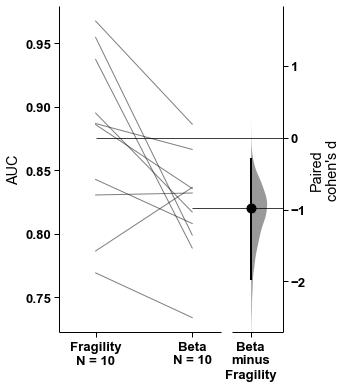

In [17]:
plt.rcParams['font.weight'] = 'bold'
sns.set_context('paper', font_scale=1.5)
fig, ax = plt.subplots(figsize=(4,6))
feature_aucs_dabest.cohens_d.plot(ax=ax)
figpath = Path(figdir) / 'discrimination_and_calibration/'
figname = f'paired_estimationplot_fragilityvsbeta_{clf_type}_quantilefeatures.pdf'
# ax.set(title="Paired Estimation Plots of \nCohen's D Effect Size Difference in AUC")
# fig.savefig(figpath / figname, 
#             bbox_inches='tight')
print('done')

# Visualize Raw EEG Data

In [65]:
# bids_root = './'

# on gigantum, set it as such
gigantum_root = Path('/mnt/labbook/')
bids_root = gigantum_root / 'input' / 'neural-fragility-demo-dataset'

In [196]:
subject = 'jh103'
session = 'presurgery'
task = 'ictal'
acquisition = 'ecog'
run = '01'
suffix = 'ieeg'

bids_path = BIDSPath(subject=subject, session=session, task=task,
                     acquisition=acquisition, run=run, suffix=suffix, root=bids_root)
print(bids_path)

/Users/adam2392/Dropbox/epilepsy_bids/sub-jh103/ses-presurgery/ieeg/sub-jh103_ses-presurgery_task-ictal_acq-ecog_run-01_ieeg.vhdr


In [197]:
# load in the raw data
raw = read_raw_bids(bids_path)

# 
raw.drop_channels(raw.info['bads'])
raw.pick_types(seeg=True, ecog=True)
raw.load_data()
print(raw)

l_freq = 0.5
h_freq = 300
line_freq = raw.info['line_freq']
nyq_freq = 300 # raw.info['sfreq'] // 2
freqs = np.arange(line_freq, max(h_freq, nyq_freq), line_freq)
raw.filter(l_freq=l_freq, h_freq=h_freq)

raw = raw.notch_filter(freqs, method='fir')

events, events_id = events_from_annotations(raw)

In [198]:
pat_df = read_clinical_excel(excel_fpath, keep_as_df=True)
display(pat_df.head())


# use excel file to set various data points
pat_row = pat_df[pat_df['PATIENT_ID'] == subject.upper()]
soz_chs = pat_row['SOZ_CONTACTS'].values[0]

print(soz_chs)

,JOURNAL_PATIENTID,PATIENT_ID,NUMBER_DATASETS,CLINICAL_CENTER,MODALITY,SFREQ,PREVIOUS SURGERY?,CLINICAL_COMPLEXITY,ENGEL_SCORE,ILAE_SCORE,...,DATE/YEAR OF SURGERY,DATE_LAST_FOLLOW_UP,YEARS_FOLLOW_UP,NOTES,PREVIOUS - FOLLOWUP,UNNAMED: 39,UNNAMED: 40,UNNAMED: 41,UNNAMED: 42,UNNAMED: 43
0,PATIENT_1,PT1,4.0,NIH,ECOG,1000.0,n/a,1.0,1.0,2.0,...,NAT,2019-05-15,3.0,n/a,2017-04-26,n/a,n/a,n/a,n/a,n/a
1,PATIENT_2,PT2,3.0,NIH,ECOG,1000.0,n/a,1.0,1.0,1.0,...,NAT,2020-01-16,3.0,n/a,2017-03-16,n/a,n/a,n/a,n/a,n/a
2,PATIENT_3,PT3,2.0,NIH,ECOG,1000.0,n/a,3.0,1.0,1.0,...,NAT,2017-03-02,2.0,n/a,2017-03-02,n/a,n/a,n/a,n/a,n/a
3,PATIENT_4,PT6,3.0,NIH,ECOG,1000.0,n/a,4.0,2.0,5.0,...,NAT,2019-01-03,3.0,n/a,2016-12-09,n/a,n/a,n/a,n/a,n/a
4,PATIENT_5,PT7,3.0,NIH,ECOG,1000.0,n/a,3.0,3.0,1.0,...,NAT,2020-02-14,7.0,n/a,2017-04-26,n/a,n/a,n/a,n/a,n/a


['RTG40', 'RTG48', 'RAD1', 'RAD2', 'RAD3', 'RAD4', 'RAD5', 'RAD6', 'RAD7', 'RAD8', 'RHD1', 'RHD2', 'RHD3', 'RHD4', 'RHD5', 'RHD6', 'RHD7', 'RHD8', 'RHD9']


In [199]:
chs_to_plot = soz_chs.copy()
if subject == "pt1":
    chs_to_plot.extend(
        ["ilt1", "ilt2", "ilt3", "ilt4",
#         "mlt1", "mlt2", "mlt3", "mlt4",
#          "slt1", "slt2", "slt3", "slt4",
        ]
    )
elif subject == "jh103":
    chs_to_plot.extend(
        [
            "abt1", "abt2",
#             "pbt1", "ptbt2", "pbt3", "pbt4",
#          "rtg5", "rtg6", "rtg7",  "rtg8",  "rtg9",  "rtg10",
            "rtg29", "rtg30", "rtg31",  "rtg32",  
#             "rtg33",  "rtg34",
#            "rtg39", "rtg35", "rtg36",  "rtg37",  "rtg38",  
        ]
    )
elif subject == "la08":
    chs_to_plot.extend(
        [
           "x'1", "f'2", "n'4", "n'5", "n'6", "m'4", "m'5", "u'1", "u'2", "u'3",
        ]
    )
    
chs_to_plot = [ch.upper() for ch in chs_to_plot]

In [200]:
# find the seizure onset and offset
sz_onset_id, sz_offset_id = _find_sz_id(events_id, verbose=False)

print(sz_onset_id)
# sz_onset_id = 10008
sz_event = events[np.where(events[:, -1] == sz_onset_id)]
sz_onset = sz_event[0][0].squeeze()

print(events_id)
print(sz_event)
print(sz_onset)

10022
{'+0.000000': 10001, '+105.000000': 10002, '+111.000000': 10003, '+118.000000': 10004, '+125.000000': 10005, '+139.000000': 10006, '+160.000000': 10007, '+60.000000': 10008, '+62.000000': 10009, '+65.000000': 10010, '+69.000000': 10011, '+71.000000': 10012, '+80.000000': 10013, '+82.000000': 10014, '+83.000000': 10015, '+84.000000': 10016, '+86.000000': 10017, '+95.000000': 10018, '+96.000000': 10019, '+98.000000': 10020, 'A1+A2 OFF': 10021, 'SZ EVENT # (PB SZ)': 10022, 'Schedule': 10023, 'Segment: REC START REC EEG': 10024, 'Z BLINKING': 10025, 'Z DEVOLUTION': 10026, 'Z DROOLING': 10027, 'Z GENERALIZE': 10028, 'Z ICTAL BUILD': 10029, 'Z OPENS MOUTH, HEAD': 10030, 'Z OXYGEN STARTING': 10031, 'Z POST-ICTAL DEPRESS': 10032, 'Z RHD 39-40, 47-48': 10033, 'Z RHD>RAD': 10034, 'Z RHY ALPHA RHD5': 10035, 'Z SCREAMING': 10036, 'Z SEMIRHY SLOW RHD': 10037, 'Z SLEEPING': 10038, 'Z SPK/SLW RAD, RHD>A': 10039, 'Z SPREAD TO RHD, ABT': 10040, 'Z STIFFENING': 10041, 'Z TURNED ON SIDE': 10042, 'Z

In [201]:
start = sz_onset / raw.info['sfreq'] - 10#.*raw.info['sfreq']

chinds = [i for i, ch in enumerate(raw.ch_names) if ch in chs_to_plot]
raw._first_samp = start

In [202]:
raw.resample(30)
print(raw)
raw.load_data()

<RawBrainVision | sub-jh103_ses-presurgery_task-ictal_acq-ecog_run-01_ieeg.eeg, 88 x 6185 (206.1 s), ~4.3 MB, data loaded>


<RawBrainVision | sub-jh103_ses-presurgery_task-ictal_acq-ecog_run-01_ieeg.eeg, 88 x 6185 (206.1 s), ~4.3 MB, data loaded>

In [203]:
raw.set_annotations(None)

<RawBrainVision | sub-jh103_ses-presurgery_task-ictal_acq-ecog_run-01_ieeg.eeg, 88 x 6185 (206.1 s), ~4.3 MB, data loaded>

Figure(747x576)


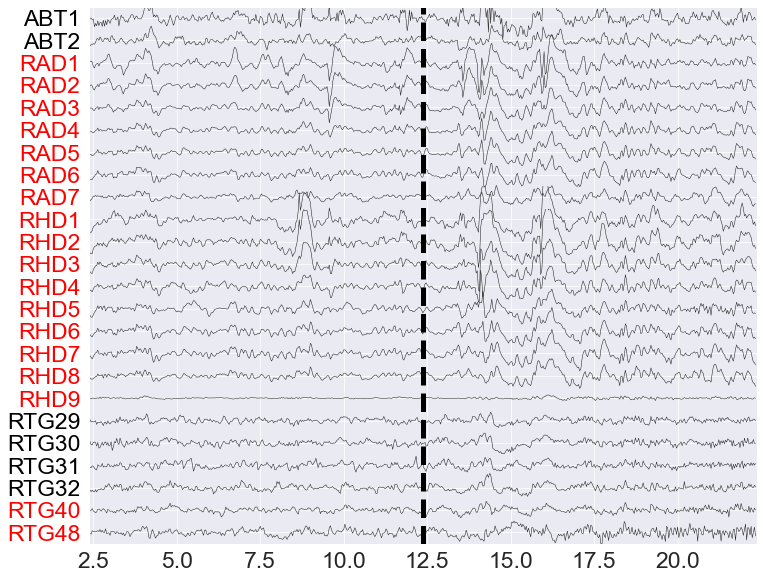

In [206]:

sns.set(context="paper", 
        font_scale=2.6
       )
# matplotlib.rc('figure', figsize=(25, 7))

fig = raw.plot(
            events=None,
            duration=20, 
            n_channels=len(chinds),
            color={"eeg": "black", 
                   "seeg": 'black'},
             order=chinds,
             scalings={
                 'seeg': 5e-4,
                 'ecog': 2e-4, 
#                        'eog': 5e-4
                      },
#             decim=2,
#         show_first_samp=True, 
        show=False,
#          clipping='clamp',
         start=start, 
        show_scrollbars=False,
        show_scalebars=False,
              )

ax = fig.axes[0]
# ax.set_xticks(np.linspace(0, 20, 9))
ax.set_xticklabels(np.linspace(0, 20, 9))

xlim = ax.get_xlim()
ax.axvline(np.mean(xlim), lw=5, color='black', ls='--')

yticklabels = ax.get_yticklabels()
# set colors based on lists passed in
for idx, y_label in enumerate(yticklabels):
    y_ch = y_label.get_text()
    
    if y_ch in soz_chs:
        color = 'red'
    else:
        color = 'black'


    # set the color for each of these ylabels
    yticklabels[idx].set_color(color)

# fig.set_figwidth(12)
fig.set_figheight(8)
fig.savefig(figdir / 'figure3-exampleheatmaps' / 'raweeg' / f"raw_{subject}_eeg_{reference}.pdf", 
            dpi=1000,
            bbox_inches="tight")
print(fig)